# Variational Autoencoder

Autoencoders are neural network architectures used to:
* Encoder data - Create lower-dimension representations of input data.
* Decode data - From these lower-dimension representations, re-create the input data.

Variational autoencoders are a form of autoencoder that learns latent (lower-dimensional) *distribution* of inputs' mean and standard deviation. There is then a **sampling** layer after the latent encoding layer that samples from these mean and standard deviation distributions, 'generating' a new, realistic synthetic observation.

In [69]:
# Commented out for non-Colab user

# # re upload files everytime run

# from google.colab import files

# uploaded = files.upload()

# Environment Set-up

## Libraries

In [7]:
## Load libraries

# Data manipulation
import pandas as pd
import numpy as np
print('numpy: %s' % np.__version__)

# Deep learning
from tensorflow import keras
print('Tensorflow/Keras: %s' % keras.__version__)

from keras.models import Model
from keras import Input
from keras.layers import Dense, Lambda
from tensorflow.keras.utils import plot_model
from keras import backend as K

# Plotting
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.facecolor'] = 'white' # Since I use a dark IDE
print('matplotlib: %s' % matplotlib.__version__)

import graphviz
print('graphviz: %s' % graphviz.__version__)

import plotly
import plotly.express as px
print('plotly: %s' % plotly.__version__)

# Other
import sys
import os

main_dir=os.path.dirname(sys.path[0])
print('main dir: %s' % main_dir)

numpy: 1.22.3
Tensorflow/Keras: 2.9.0
matplotlib: 3.5.1
graphviz: 0.20.1
plotly: 5.10.0
main dir: /Users/benjamintan/Library/CloudStorage/OneDrive-TheUniversityofWesternAustralia/Master of Data Science/Year 2/Semester 2/CITS5553/CITS5553-Capstone-Project/GAN


## Loading Data

In [8]:
import pandas as pd

X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


(191, 120)
(191, 1)
(48, 120)
(48, 1)


## Data Standardisation

In [9]:
from sklearn.preprocessing import MinMaxScaler

# Scale all columns to (0,1) range
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

# VAE

### Sampling Layer + Reparameterization Trick

The sampling layer samples from the distributions in the latent layer. However, this makes it difficult to train the network using backpropagation. Backpropagation involves calculating the change in error/loss function with respect to changes in model weights. However, this layer involves *sampling* from distributions in the previous layer and the 'randomness' of sampling means that the aforementioned differentiation cannot be calculated. This makes the sampling layer a 'blockage' to backpropagation.\
\
To tackle this, the **reparameterization trick** is used. By making the latent vector $\mu + \sigma * \epsilon$ (i.e., multiplying $\sigma$ by $\epsilon$), where $\epsilon$ ~ Norm(0,1), a neuron is added to the sampling layer which allows backpropagation to continue through previous layers. **Read more

In [10]:
def sampling(args):
  z_mean, z_log_sigma = args
  epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=1.) ## reparameterisation trick
  return z_mean + K.exp(z_log_sigma) * epsilon

### Encoder

In [15]:
## Encoder

original_dim = 120
latent_dim = 2

visible = keras.Input(shape=(original_dim,), name='Encoder-Input-Layer')

h_enc1 = Dense(units=64, activation='relu', name='Encoder-Hidden-Layer-1')(visible)
h_enc2 = Dense(units=16, activation='relu', name='Encoder-Hidden-Layer-2')(h_enc1)
h_enc3 = Dense(units=8, activation='relu', name='Encoder-Hidden-Layer-3')(h_enc2)

z_mean = Dense(units=latent_dim, name='Z-Mean')(h_enc3)
z_log_sigma = Dense(units=latent_dim, name='Z-Log-Sigma')(h_enc3)
z = Lambda(sampling, name='Z-Sampling-Layer')([z_mean, z_log_sigma])

encoder = Model(visible, [z_mean, z_log_sigma, z], name='Encoder-Model')

plot_model(encoder, show_shapes=True, dpi=300)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [6]:
## Decoder

latent_inputs = Input(shape=(latent_dim,), name='Input-Z-Sampling')

h_dec = Dense(units=8, activation='relu', name='Decoder-Hidden-Layer-1')(latent_inputs)
h_dec2 = Dense(units=16, activation='relu', name='Decoder-Hidden-Layer-2')(h_dec)
h_dec3 = Dense(units=64, activation='relu', name='Decoder-Hidden-Layer-3')(h_dec2)

outputs = Dense(original_dim, activation='sigmoid', name='Decoder-Output-Layer')(h_dec3)

decoder = Model(latent_inputs, outputs, name='Decoder-Model')

plot_model(decoder, show_shapes=True, dpi=300)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [77]:
## Autoencoder

outpt = decoder(encoder(visible)[2])
vae = Model(inputs=visible, outputs=outpt, name='VAE-Model')

In [78]:
## Loss Function

r_loss = original_dim * keras.losses.mse(visible, outpt)
kl_loss = -0.5 * K.sum(1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma), axis = 1)
vae_loss = K.mean(r_loss + kl_loss)

vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Epoch 1/25
12/12 [==============================] - 1s 20ms/step - loss: 9.3700 - val_loss: 8.8757
Epoch 2/25
12/12 [==============================] - 0s 5ms/step - loss: 8.4356 - val_loss: 8.5039
Epoch 3/25
12/12 [==============================] - 0s 5ms/step - loss: 7.2762 - val_loss: 8.3147
Epoch 4/25
12/12 [==============================] - 0s 6ms/step - loss: 6.3060 - val_loss: 8.3409
Epoch 5/25
12/12 [==============================] - 0s 5ms/step - loss: 5.8060 - val_loss: 8.4701
Epoch 6/25
12/12 [==============================] - 0s 5ms/step - loss: 5.5088 - val_loss: 8.1483
Epoch 7/25
12/12 [==============================] - 0s 7ms/step - loss: 5.3906 - val_loss: 8.0407
Epoch 8/25
12/12 [==============================] - 0s 7ms/step - loss: 5.2010 - val_loss: 8.2194
Epoch 9/25
12/12 [==============================] - 0s 7ms/step - loss: 5.2715 - val_loss: 8.1837
Epoch 10/25
12/12 [==============================] - 0s 6ms/step - loss: 5.2534 - val_loss: 7.9501
Epoch 11/25
12/12 

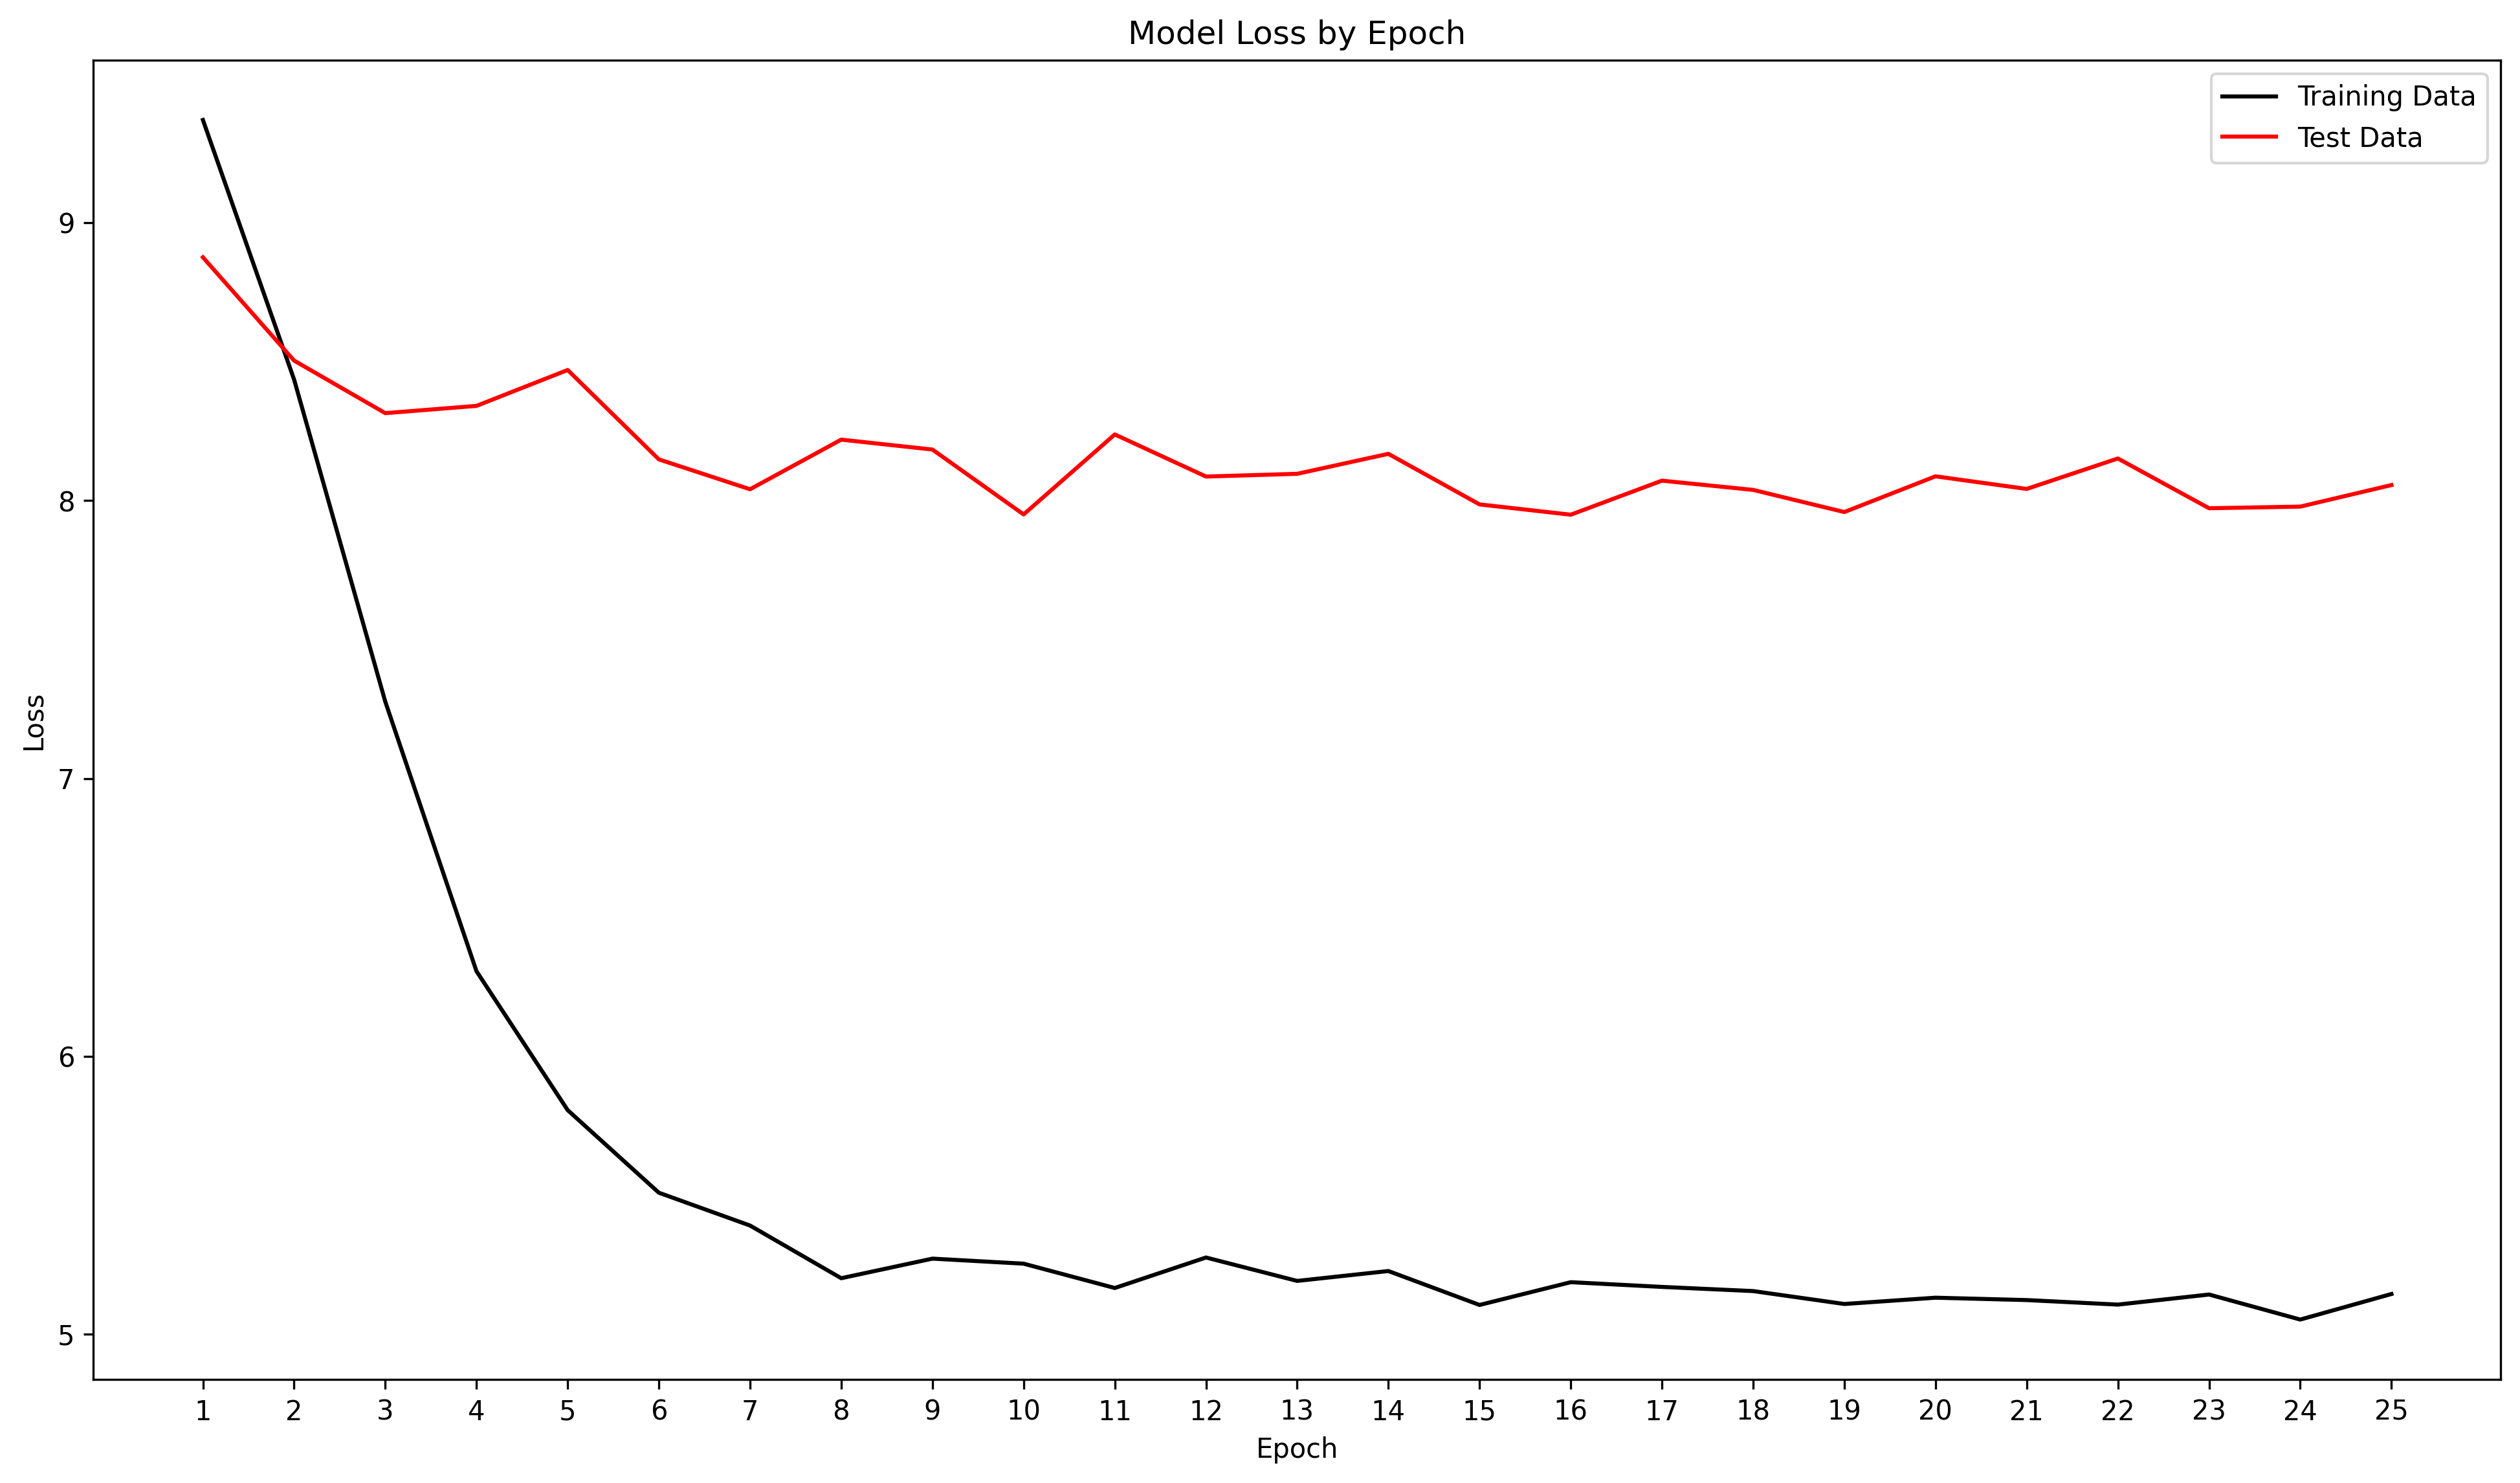

In [79]:
## Training

history = vae.fit(X_train_scaled, X_train_scaled, epochs=25, batch_size=16, validation_data=(X_test_scaled, X_test_scaled))

fig, ax = plt.subplots(figsize=(16,9), dpi=300)
plt.title(label='Model Loss by Epoch', loc='center')

ax.plot(history.history['loss'], label='Training Data', color='black')
ax.plot(history.history['val_loss'], label='Test Data', color='red')
ax.set(xlabel='Epoch', ylabel='Loss')
plt.xticks(ticks=np.arange(len(history.history['loss']), step=1), labels=np.arange(1, len(history.history['loss'])+1, step=1))
plt.legend()
plt.show()

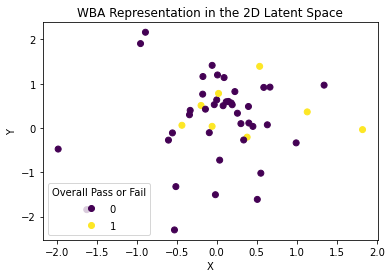

In [80]:
## Visualise Latent Space

X_test_encoded = encoder.predict(X_test_scaled)

#fig = px.scatter(None, x=X_test_encoded[2][:,0], y=X_test_encoded[2][:,1], opacity=1, color=y_test['OverallPoF'])
#fig.update_layout(dict(plot_bgcolor = 'white'))
#fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='white', zeroline=True, zerolinewidth=1, zerolinecolor='white', showline=True, linewidth=1, linecolor='white', title_font=dict(size=10), tickfont=dict(size=10))
#fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='white', zeroline=True, zerolinewidth=1, zerolinecolor='white', showline=True, linewidth=1, linecolor='white', title_font=dict(size=10), tickfont=dict(size=10))
#fig.update_layout(title_text="WBA representation in the 2D Latent Space")
#fig.update_traces(marker=dict(size=2))
#fig.show()

fig, ax = plt.subplots()
# encoder returns 3 arrays, z-mean, z-log-sigma, z
scatter = ax.scatter(X_test_encoded[2][:,0], X_test_encoded[2][:,1], c=y_test['OverallPoF'])
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_title("WBA Representation in the 2D Latent Space")
ax.legend(*scatter.legend_elements(), loc="lower left", title="Overall Pass or Fail")
plt.show()

In [81]:
## Generate from latent space

z_sample = [[-1.8,-0.3]]
wba_decoded = decoder.predict(z_sample)
wba_decoded[0]

array([0.4807853 , 0.35664058, 0.32919323, 0.79246944, 0.22428548,
       0.05383477, 0.6296013 , 0.56006557, 0.56869465, 0.5313701 ,
       0.4718635 , 0.47139424, 0.1813891 , 0.02586007, 0.03870937,
       0.07262346, 0.10217789, 0.12406906, 0.11797783, 0.14174819,
       0.18326843, 0.18945122, 0.22208253, 0.23436657, 0.26832113,
       0.2926677 , 0.2708559 , 0.2677303 , 0.29118687, 0.29922462,
       0.2959546 , 0.29914913, 0.3054288 , 0.3076778 , 0.29696822,
       0.28795648, 0.2986737 , 0.34178042, 0.2965685 , 0.29904258,
       0.30830184, 0.31632286, 0.32518563, 0.34352165, 0.35337108,
       0.3562326 , 0.34131214, 0.3843698 , 0.41209644, 0.41911614,
       0.4762193 , 0.46481162, 0.47273797, 0.49539185, 0.53291845,
       0.5537621 , 0.5665449 , 0.6109045 , 0.62706095, 0.63477606,
       0.6383422 , 0.63401836, 0.60863703, 0.6040223 , 0.5994128 ,
       0.63828707, 0.63031006, 0.6293673 , 0.65755343, 0.67844164,
       0.71602863, 0.69659436, 0.6722521 , 0.6857247 , 0.70730

In [87]:
from random import seed
from random import random

seed(1)

n_samples = 10000
z_sample = []

for _ in range(n_samples):
  x_value = -3 + (random() * (3--3))
  y_value = -6 + (random() * (6--6))
  z_sample.append([x_value, y_value])

wba_decoded = decoder.predict(z_sample)
unscaled = scaler.inverse_transform(wba_decoded)
pd.DataFrame(unscaled).to_csv('sample.csv')